Exploring the output files generated by the Salish Sea Atlantis Model
to try to reeduce PAH build-up in the biopools.

Test scenarios
1. reduce contam decay timestep to bm -> dt (changed time_step to bm->dt for all contam species decay atContaminants.c line 1077)
1. changed the PAH half_life from being denominated in seconds -> days

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

In [2]:
bmdt_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_bmdt/outputSalishSea.nc"
half_life_days_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_halflife_days/outputSalishSea.nc"

bmdt = xr.open_dataset(str(bmdt_file), decode_cf=True)
hldays = xr.open_dataset(str(half_life_days_file), decode_cf=True)
time = np.ma.filled(bmdt.variables['t'], np.nan)

Check for contaminant injection

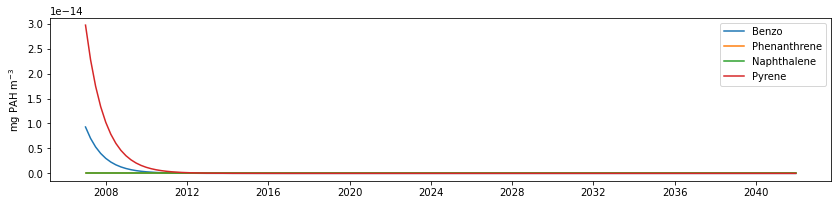

In [5]:
fig, ax = plt.subplots(figsize = (14,3))
for pah in groups.pahs:
    contam = np.ma.filled(bmdt.variables[pah], np.nan)
    contam = contam.sum(axis=2)
    contam = contam.sum(axis=1)

    ax.plot(time, contam)
ax.legend(groups.pahs)
ax.set_ylabel('mg PAH m$^{-3}$');

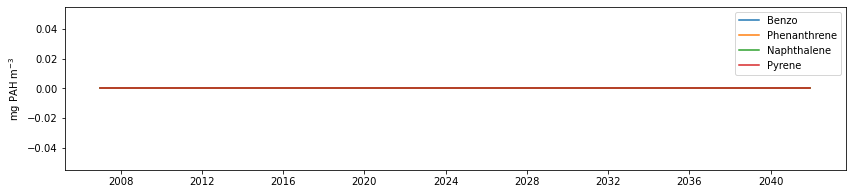

In [6]:
fig, ax = plt.subplots(figsize = (14,3))
for pah in groups.pahs:
    contam = np.ma.filled(hldays.variables[pah], np.nan)
    contam = contam.sum(axis=2)
    contam = contam.sum(axis=1)

    ax.plot(time, contam)
ax.legend(groups.pahs)
ax.set_ylabel('mg PAH m$^{-3}$');

The run.prm file for the above scenarios did not match the spill file. It skipped first 15 years for burn-in. Use run_contan_test.prm instead

In [7]:
def tissue_concentration(group, pah, scens):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    names = ['bm->dt', 'half_life_days']

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:

            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_' + pah][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(time, pelagic_oiled, linewidth = 2) #semilogy
        
        plt.ylabel('mg PAH', fontsize=12)
        ax.legend(names)
        ax.set_title(species);

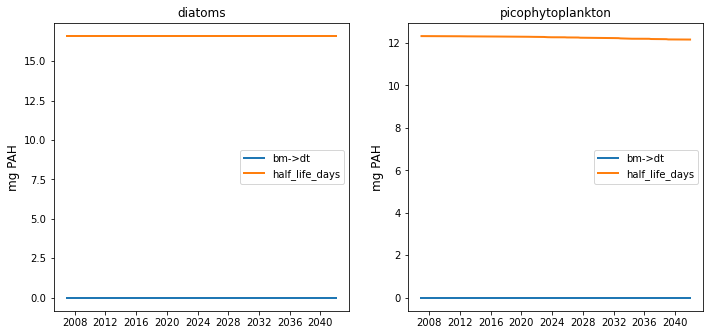

In [8]:
scens = [bmdt, hldays]
tissue_concentration(groups.phytoplankton, 'Pyrene',scens)

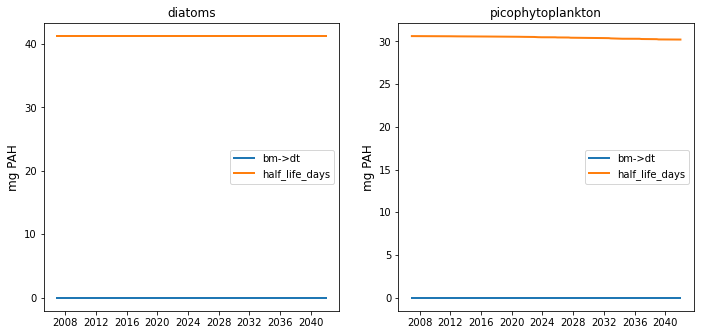

In [9]:
tissue_concentration(groups.phytoplankton,'Naphthalene',scens)

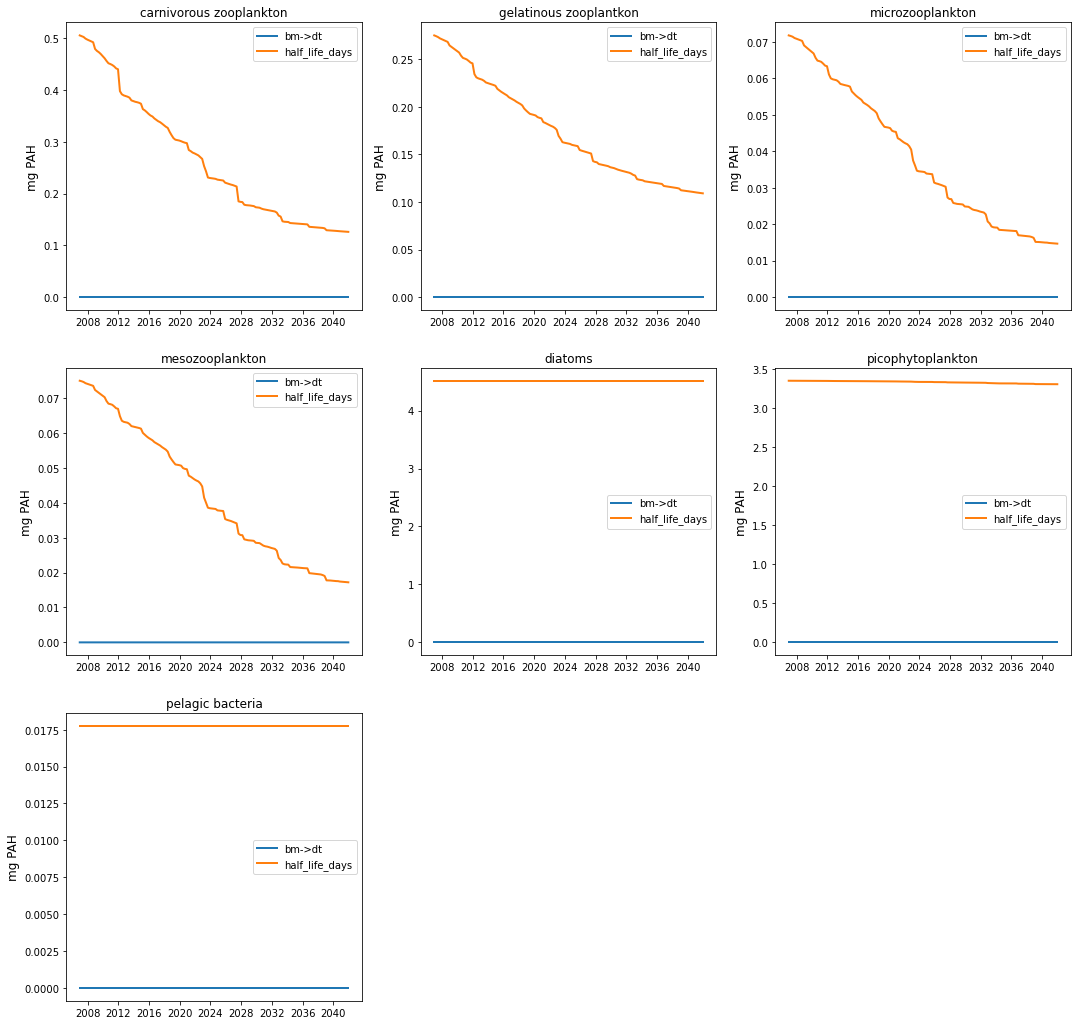

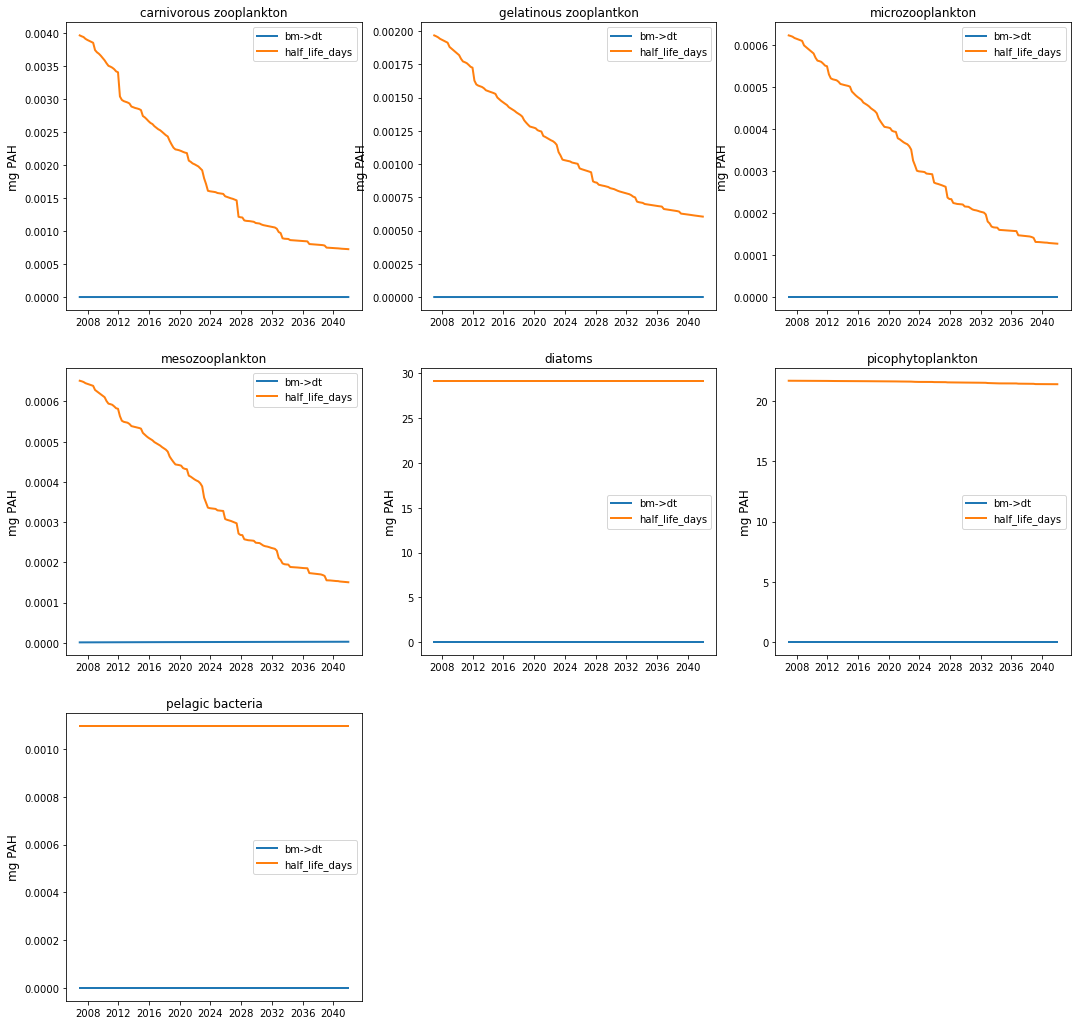

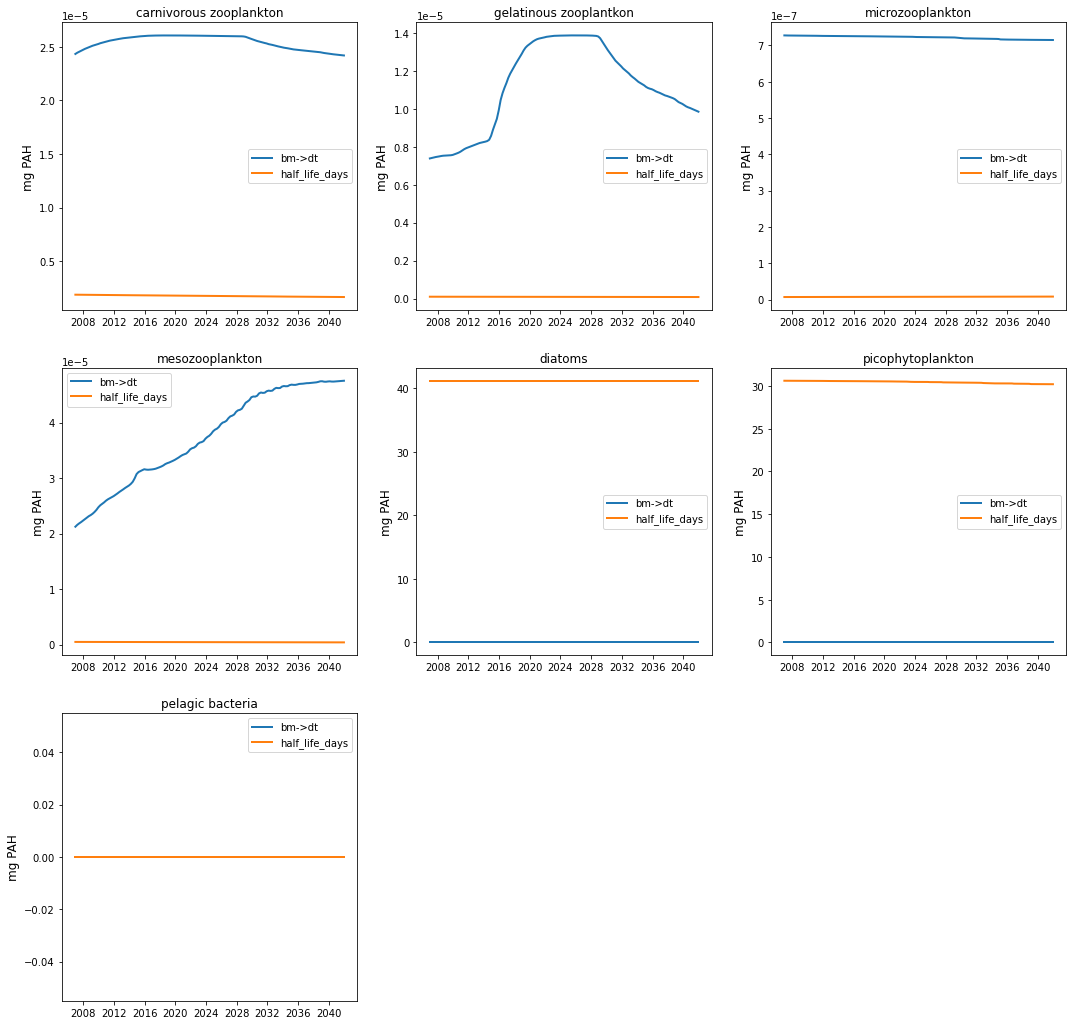

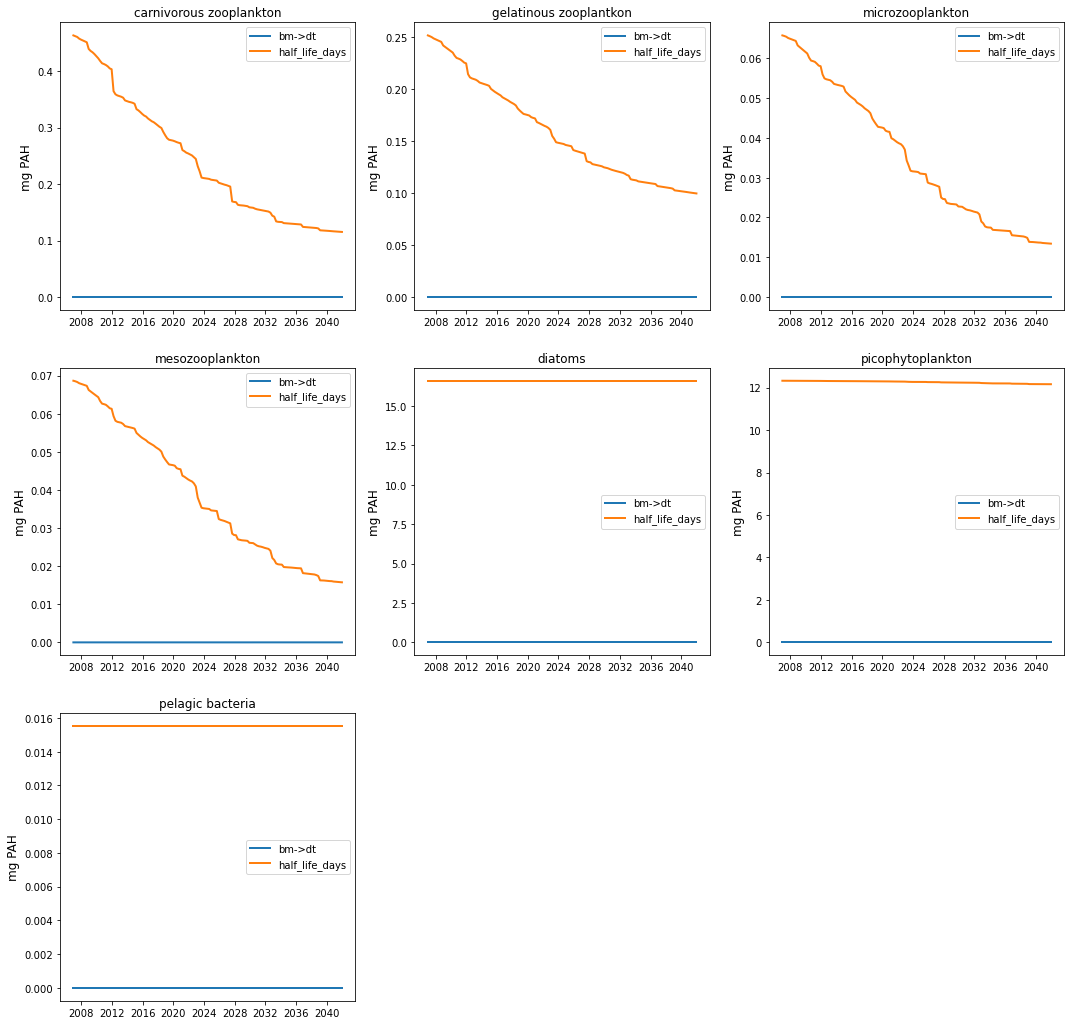

In [10]:
for pah in groups.pahs:
    tissue_concentration(groups.plankton, pah, scens)